In [1]:
%matplotlib inline
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_printing()

This notebook will eventually document the math behind our version of the [Sprint Distance Calculation Spreadsheet](https://docs.google.com/spreadsheets/d/1CgQndEH24WoJ2kOAaqqsNnNZ17qxCoh7hsNyRDelmXU/edit#gid=1923872016&range=A1). For now, you can just copy and use that spreadsheet directly.

The goal is to determine the minimum time required for our robot to go from stopped at one position to stopped at another position some fixed distance away. One step  in figuring that out is determining the maximum acceleration, $a$, the robot can achieve at each point along the way. That acceleration depends on the traction force provided by the wheel $F_{traction}$, and the robot's mass $m$, according to Newton's First Law, **(1)**:

In [2]:
a, F_traction = symbols('a F_traction', real=True, finite=True, nonzero=True)
m = symbols('m', real=True, finite=True, positive=True)
rel1 = Eq(F_traction, m*a)
rel1

Solving for acceleration gives **(2)**:

In [3]:
rel2=solveset(rel1,a).as_relational(a)
display(rel2)

The maximum traction before wheels slip is determined by the coefficient of static friction of the wheel with the floor ($\mu$) and the normal force of the carpet on the wheels ($F_{normal}$) according to **(3)**:

In [4]:
F_normal = symbols('F_normal', real=True, finite=True, nonzero=True)
mu = symbols('mu', real=True, finite=True, positive=True)
rel3 = Le(F_traction, mu*F_normal)
rel3

On a flat field, $F_{normal}$ is the the force of gravity on the mass of the robot, as given by **(4)**:

In [5]:
g = symbols('g', real=True, finite=True, nonzero=True)
rel4 = Eq(F_normal, m*g)
rel4

Substituting (4) into (3) gives **(5)**:

In [6]:
rel5=rel3.subs(rel4.lhs,rel4.rhs)
rel5

$F_{traction}$ depends on the torque ($\tau$) provided by the motors/gearboxes and the radius of the wheels, $r$ according to **(6)**.

In [7]:
r = symbols("r", real=True, finite=True, positive=True)
tau = symbols("tau", real=True, finite=True, nonzero=True)
rel6 = Eq(tau,F_traction*r)
rel6

For simplicity, we'll model the robot as having one wheel powered by a gearmotor equivalent to all of the motors and gearboxes on a real robot.

To find the maximum torque to avoid slipping, we substitute (5) into (6) to get **(7)**:

In [8]:
rel7 = Le(rel6.lhs, rel6.rhs.subs(rel5.lhs, rel5.rhs))
rel7

The torque varies directly with the current flowing through the motor windings $I_m$ according to the gearmotor's torque constant $K_T$, per **(8)**:

In [9]:
K_T = symbols("K_T", real=True, finite=True, positive=True)
I_m = symbols("I_m", real=True, finite=True, nonzero=True)
rel8 = Eq(tau, K_T*I_m)
rel8

To find the limit on $I_m$ to avoid slipping the wheels we solve (8) for $I_m$ and substitute the limit on $\tau$ from (7) to get **(9)**

In [10]:
rel9=solveset(rel8,I_m).as_relational(I_m)
rel9=Le(rel9.lhs, rel9.rhs.subs(rel7.lhs, rel7.rhs))
rel9

$I_m$ varies directly with the voltage across the windings ($V_m$) and inversely with the resistance of the windings ($R_m$), in accordance with Ohm's Law **(10)**:

In [11]:
V_m = symbols("V_m", real=True, finite=True, nonzero=True)
R_m = symbols("R_m", real=True, finite=True, positive=True)
rel10 = Eq(I_m, V_m/R_m)
rel10

$V_m$ is the voltage supplied by the motor controller ($V_c$) minus the back voltage caused by the motor acting like a generator. The back voltage varies directly with the speed of the gearmotor ($\omega$) divided by the gearmotor's speed constant ($K_v$). That gives **(11)**: 

The maximum torque (and thus maximum acceleration) at any time is determined by:

* Traction. Too much torque and the wheels slip.
* Maximum current that can flow from the motor controllers through the windings of motors. This may be limited by the specs for the controllers on the motors.
* Maximum current that can flow into the motors. This can be limited by the breakers on the circuits that supply power to the motors, the main breaker, or the current draw that the battery can support.

In [12]:
w = symbols("omega", real=True, finite=True)
K_v = symbols("K_v", real=True, finite=True, positive=True)
V_c = symbols("V_c", real=True, finite=True)
rel11 = Eq(V_m, V_c-w/K_v)
rel11

$V_c$ is a percentage ($p$) of the voltage at the motor controller input ($V_{in}$), per **(12)**:

In [13]:
V_in, p = symbols("V_in p", real=True, finite=True, positive=True)
rel12 = Eq(V_c, p*V_in)
rel12

In addition, the current flowing into the motor controller ($I_{in}$) is the same percentage of the current flowing through the motor windings ($I_m$). That is **(13)**:

In [14]:
I_in = symbols("I_in", real=True, finite=True)
rel13 = Eq(I_in, p*I_m)
rel13

The current flowing into the motor controller is also flowing through the battery, battery cables, PDP, and the motor controller power wires. All of those have a combined resistance $R_{sys}$ and the current flowing through that resistance results in a voltage difference between the voltage at the battery, $V_{bat}$, and the voltage at the input to the motor controller, $V_{in}$ **(14)**:

In [15]:
V_bat = symbols("V_bat", real=True, finite=True, nonnegative=True)
R_sys = symbols("R_sys", real=True, finite=True, positive=True)
rel14 = Eq(V_bat-V_in, I_in*R_sys)
rel14

Combining (10) through (14), we can find a formula for $I_m$ in terms of $p$, $\omega$, and the various constants **(15)**:

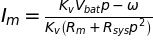

In [16]:
rel15_1 = solveset(rel14,V_in).as_relational(V_in)
display(rel15_1)
rel15_2 = rel15_1.subs(rel13.lhs, rel13.rhs)
display(rel15_2)
rel15_3 = rel12.subs(rel15_2.lhs,rel15_2.rhs)
display(rel15_3)
rel15_4 = rel11.subs(rel15_3.lhs,rel15_3.rhs)
display(rel15_4)
rel15_5 = rel10.subs(rel15_4.lhs,rel15_4.rhs)
display(rel15_5)
rel15_6 = solveset(rel15_5,I_m).as_relational(I_m)
display(rel15_6)

To simplify future algebra, let's introduce a new variable, $\omega_\%$, which is the fraction of the speed that produces a back voltage of $V_{bat}$

In [17]:
w_f=symbols("\\omega_\%",real=True,finite=True)
w_f_def=Eq(w_f,(w/K_v)/V_bat)
display(w_f_def)

Solving for $\omega$ and substituting our definition for $\omega_\%$ into our equation for $I_m$ gives:

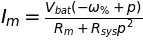

In [18]:
w_from_w_f = solveset(w_f_def,w).as_relational(w)
display(w_from_w_f)
I_m_from_p_w_f = factor(rel15_6.subs(w_from_w_f.lhs, w_from_w_f.rhs))
display(I_m_from_p_w_f)

Here's a plot of $I_m$ against $\omega_\%$ and $p$ for $V_{bat}=12$ Volts.

In [19]:
plt.close('all')

@interact(Rm_mohms=widgets.FloatSlider(min=5,max=150,step=1,description=r'\(R_m\)(\(m\Omega\))'), 
          Rsys_mohms=widgets.FloatSlider(min=5,max=40,step=1,description=r'\(R_{sys}\)(\(m\Omega\))'))
def plot_I_m_surface(Rm_mohms=10,Rsys_mohms=20):
    p = np.arange(-100, 100, 10)
    w_percent = np.arange(0, 100, 10)
    p, w_percent = np.meshgrid(p, w_percent)
    I_m = 12*(p/100.0-w_percent/100.0)/(Rm_mohms/1000.0+Rsys_mohms/1000.0*(p/100)**2)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(r'$p$ (%)')
    ax.set_ylabel(r'$\omega_\%$ (%)')
    ax.set_zlabel(r'$I_m$ (Amps)')
    ax.plot_surface(p, w_percent, I_m, rstride=1, cstride=1, cmap=cm.viridis)
    plt.show()

interactive(children=(FloatSlider(value=5.0, description='\\(R_m\\)(\\(m\\Omega\\))', max=150.0, min=5.0, step…

And here is a slice for a $\omega_\%$ that you provide:

In [20]:
plt.close('all')

@interact(w_percent=widgets.FloatSlider(min=0,max=100,step=5,value=0.0, description=r'\(\omega_\%\)(%)'), 
          Rm_mohms=widgets.FloatSlider(min=5,max=150,step=1,value=10.0,description=r'\(R_m\)(\(m\Omega\))'), 
          Rsys_mohms=widgets.FloatSlider(min=15,max=100,step=1,value=20.0,description=r'\(R_{sys}\)(\(m\Omega\))'))
def plot_I_m_line(w_percent=0,Rm_mohms=10,Rsys_mohms=20):
    p = np.linspace(-100.0, 100.0)
    I_m = 12*(p/100.0-w_percent/100.0)/(Rm_mohms/1000.0+Rsys_mohms/1000.0*(p/100)**2)
    I_in = I_m*p/100
    fig = plt.figure()
    plt.xlabel(r'$p$ (%)')
    plt.ylabel(r'$I_m$ (Amps)')
    plt.grid()
    plt.plot(p,I_m)
    plt.plot(p,I_in)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='\\(\\omega_\\%\\)(%)', step=5.0), FloatSlider(value=…

To maximize acceleration, we need to maximize torque, and to maximize torque we need to maximize $I_m$ subject to various constraints. Before looking at the constraints, let's find the unconstrained maximum. First, set the derivative equal to 0:

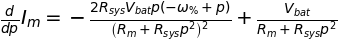

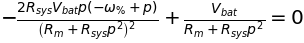

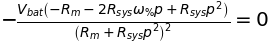

In [21]:
dIm_dp=diff(I_m_from_p_w_f.rhs,p)
display(Eq(diff(I_m,p,evaluate=false), dIm_dp))
rel16=Eq(dIm_dp,0)
display(rel16)
rel16=Eq(factor(rel16.lhs),rel16.rhs)
display(rel16)
rel16=Eq(fraction(rel16.lhs)[0]/(-V_bat),rel16.rhs)
rel16

and solve for $p$ to find the stationary points:

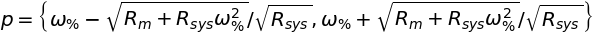

In [22]:
sols = solveset(rel16,p)
display(Eq(p,sols,evaluate=false))